Demonstrate making and applying calibration

In [1]:
import importlib
from mkids import TopSoc
import numpy as np
import matplotlib.pyplot as plt
import Scan
soc = TopSoc()

In [2]:
fMixer = soc.fsIn/2/2
soc.set_mixer(fMixer)
f0 = fMixer + 85.4
f1 = fMixer + 95.6
fTone = 0.5*(f0+f1)

measure nominal dealy for fTone=1114.500000  outCh=45


  0%|          | 0/20 [00:00<?, ?it/s]

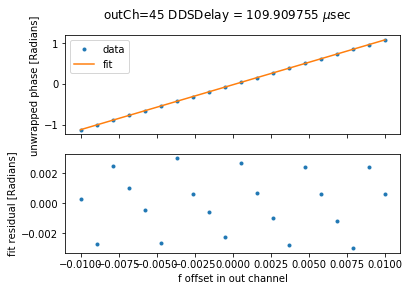

In [3]:
importlib.reload(Scan)
scan = Scan.Scan(soc)
outCh = scan.soc.outFreq2ch(fTone)
print("measure nominal dealy for fTone=%f  outCh=%d"%(fTone, outCh))
nominalDelay = scan.measureNominalDelay(outCh, decimation=2, doProgress=True, doPlot=True)

In [4]:
nf = 51
nf = 201
nt = 10
nt,nf = 1,51
nt,nf = 10,201
print("nominalDelay =",nominalDelay)
calibration = scan.makeCalibration(fMixer, f0, f1, nf=nf, nt=nt, doProgress=True,
                            nominalDelay=nominalDelay)
fscan = calibration['fscan']
print("delayApplied =",fscan['delayApplied'])


nominalDelay = 109.90975500214677


  0%|          | 0/201 [00:00<?, ?it/s]

 in MakeCalibration:  i, f0, f1 0 1109.25 1109.75
 in MakeCalibration:  i, f0, f1 1 1109.75 1110.25
 in MakeCalibration:  i, f0, f1 2 1110.25 1110.75
 in MakeCalibration:  i, f0, f1 3 1110.75 1111.0
 in MakeCalibration:  i, f0, f1 4 1111.0 1111.25
 in MakeCalibration:  i, f0, f1 5 1111.25 1111.75
 in MakeCalibration:  i, f0, f1 6 1111.75 1112.25
 in MakeCalibration:  i, f0, f1 7 1112.25 1112.75
 in MakeCalibration:  i, f0, f1 8 1112.75 1113.0
 in MakeCalibration:  i, f0, f1 9 1113.0 1113.25
 in MakeCalibration:  i, f0, f1 10 1113.25 1113.75
 in MakeCalibration:  i, f0, f1 11 1113.75 1114.25
 in MakeCalibration:  i, f0, f1 12 1114.25 1114.75
 in MakeCalibration:  i, f0, f1 13 1114.75 1115.0
 in MakeCalibration:  i, f0, f1 14 1115.0 1115.25
 in MakeCalibration:  i, f0, f1 15 1115.25 1115.75
 in MakeCalibration:  i, f0, f1 16 1115.75 1116.25
 in MakeCalibration:  i, f0, f1 17 1116.25 1116.75
 in MakeCalibration:  i, f0, f1 18 1116.75 1117.0
 in MakeCalibration:  i, f0, f1 19 1117.0 1117.2

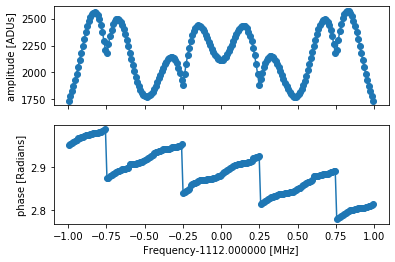

In [5]:
iTone = 2
Scan.fscanPlot(fscan, iTone)


In [6]:
spectrum = Scan.fscanToSpectrum(fscan)

f0 = 1109.4
f1 = 1119.6


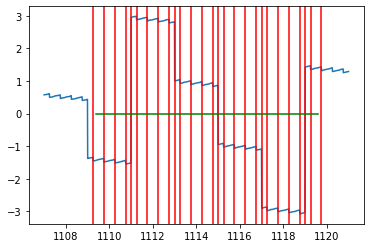

In [7]:
importlib.reload(Scan)
scan = Scan.Scan(soc)
plt.plot(spectrum[0],spectrum[2])
print("f0 =",f0)
print("f1 =",f1)
fList = scan.makeFList(fMixer, f0, f1)
for f in fList:
    plt.axvline(f,color='r')
plt.plot([f0,f1],[0,0], 'g')

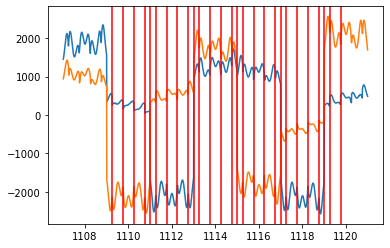

In [8]:
sx = spectrum[1]*np.exp(1j*spectrum[2])
si = np.real(sx)
sq = np.imag(sx)
plt.plot(spectrum[0],si)
plt.plot(spectrum[0],sq)
for f in fList:
    plt.axvline(f,color='r')


(1110, 1112)

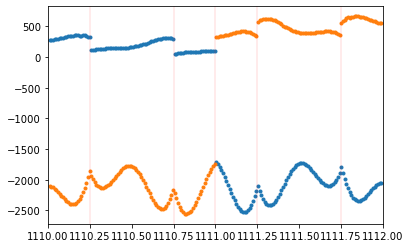

In [9]:
fStart = 1110
fEnd = 1112
inds = (spectrum[0] > fStart ) & (spectrum[0] < fEnd)
plt.plot(spectrum[0][inds],si[inds], '.')
plt.plot(spectrum[0][inds],sq[inds], '.')
for f in fList:
    plt.axvline(f,color='r', alpha=0.1)
plt.xlim((fStart,fEnd))

iCalib = 4


Text(0.5, 0, 'freq-1111.000000')

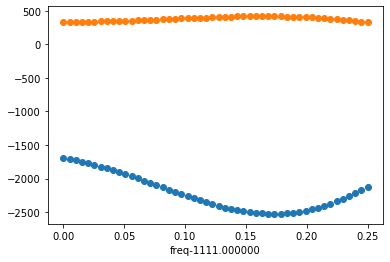

In [10]:
freq = 1111.2
iCalib = np.searchsorted(calibration['fList'], freq)-1
print("iCalib =",iCalib)
fa = calibration['fList'][iCalib]
fb = calibration['fList'][iCalib+1]
freqs = np.linspace(fa, fb)
xfit = calibration['cInterps'][iCalib](freqs)
plt.plot(freqs-fa, np.real(xfit), "o")
plt.plot(freqs-fa, np.imag(xfit), "o")
plt.xlabel("freq-%f"%fa)

In [11]:
# Pretend we have a few frequencies we want to study
testFreqs = [1110.234, 1113.456, 1115.987, 1118.456]
testAmps = 0.9*np.ones(len(testFreqs))/len(testFreqs)
np.random.seed(1234991)
testFis = np.random.uniform(0, 2*np.pi, size=len(testFreqs))
bandwidth = 0.4 # MHz
nf = 50
decimation = 2
nt = 3
doProgress = True

testFScan = scan.fscan(testFreqs, testAmps, testFis, bandwidth, nf, decimation,nt, doProgress=doProgress)


  0%|          | 0/50 [00:00<?, ?it/s]

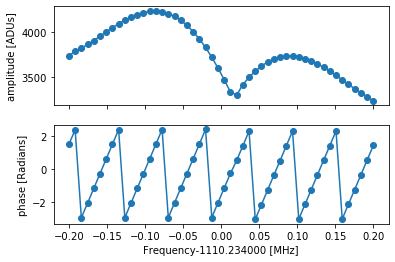

In [12]:
Scan.fscanPlot(testFScan, 0)

In [13]:
import copy
def applyCalibration(fscan, calibration):
    print("calibration keys =",calibration.keys())
    print("calibration['nominalDelay'] =",calibration['nominalDelay'])
    fscanCalib = copy.deepcopy(fscan)
    nominalDelay = calibration['nominalDelay']
    Scan.applyDelay(fscanCalib, nominalDelay)
    print(fscanCalib.keys())
    print("delay applied is",fscanCalib['delayApplied'])
    print("fscanCalib keys =",fscanCalib.keys())
    dfs = fscanCalib['dfs']
    for iTone,(freq,xs) in enumerate(zip(fscanCalib['freqs'],fscanCalib['xs'])):
        freqs = freq+dfs
        print("iTone, freq =",iTone, freq)
        xCalib = np.zeros(len(freqs), dtype=complex)
        for i, freq in enumerate(freqs):
            iCalib = np.searchsorted(calibration['fList'], freq)-1 
            xCalib[i] = calibration['cInterps'][iCalib](freq)
        gain = 30000/np.abs(xCalib)
        print("gain.shape =",gain.shape)
        print("xs itone shape =",fscanCalib['xs'][:,iTone].shape)
        fscanCalib['xs'][:,iTone] *= gain
        dfi = np.angle(xCalib)
        xs = fscanCalib['xs'][:,iTone]
        print("dfi and xs shape",dfi.shape,xs.shape)
        fscanCalib['xs'][:,iTone] = np.abs(xs)*np.exp(1j*(np.angle(xs)-dfi))
    return fscanCalib                                                     
                                                        
                                                         
#xfit = applyCalibration(testFScan, calibration)
importlib.reload(Scan)
tfsCalib = Scan.applyCalibration(testFScan, calibration, amplitudeMax=5000)


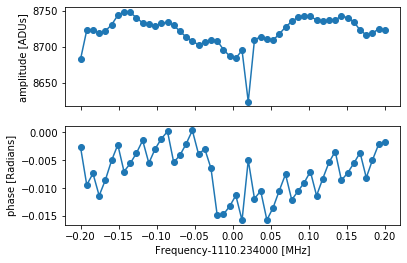

In [14]:
Scan.fscanPlot(tfsCalib, 0)